# Problem statement

Use Grover's algorithm to find solutions to the variables depicting Soduku elements as shown:

![](https://qiskit.org/textbook/ch-algorithms/images/binary_sudoku.png)

In [1]:
import numpy as np

from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram # for plotting

# Turning problem into circuit

Create a classical function on a quantum circuit to check whether the state of variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

1. v0 ≠ v1   # check along top row
2. v2 ≠ v3   # check along bottom row
3. v0 ≠ v2   # check down left column
4. v1 ≠ v3   # check down right column

In [2]:
# For convenience, we can compile this set of comparisons into a list of clauses

clause_list = [[0,1], [0,2], [1,3], [2,3]]

In [3]:
# Assign the value of each variable to a bit in the circuit. To check computationally, use XOR gate

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

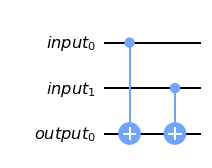

In [4]:
# We will use separate registers to name the bits

# check whether input1 == input2 and store in output
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

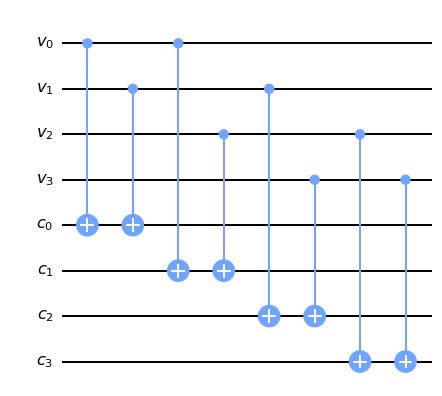

In [5]:
# To check each clause

# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

qc = QuantumCircuit(var_qubits, clause_qubits) # Create quantum circuit

i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i]) # Use XOR gate
    i += 1

qc.draw()

To complete checking circuit, the need is to have a single bit as 1 iff all clauses are satisfied. This is achieved by using a multi-controlled Toffoli-gate

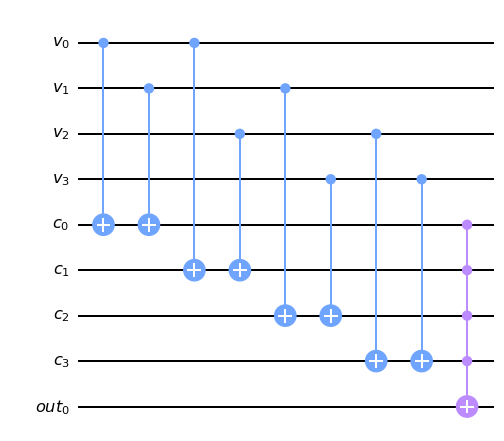

In [6]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit) # create the circuit

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.mct(clause_qubits, output_qubit) # Flip 'output' bit if all clauses are satisfied

qc.draw()

out<sub>0</sub> depicts the whether the assignment is a solution or not

* out<sub>0</sub> = 0: assignment is not a solution
* out<sub>0</sub> = 1: assignment is a solution

# Completing the Oracle

In [7]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

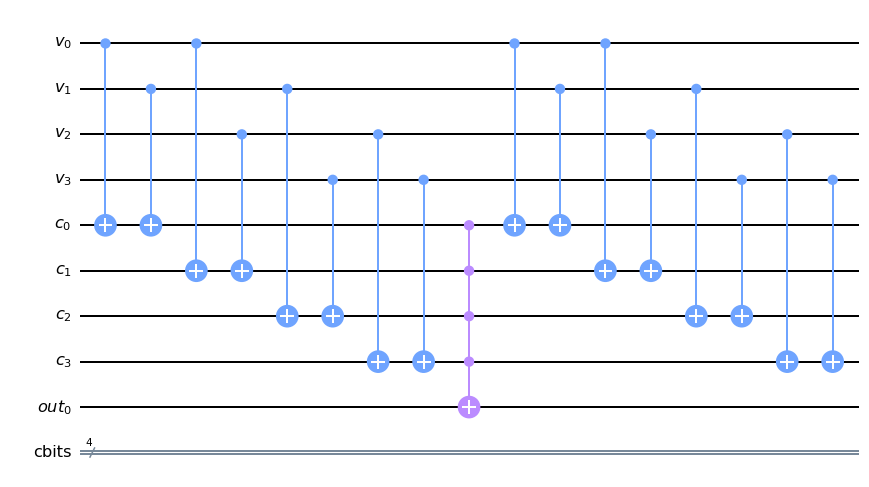

In [8]:
def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

# Put the Oracle in Grover's algorithm

In [9]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

In [10]:
qc.initialize([1, -1]/np.sqrt(2), output_qubit) # Initialize 'out0' in state |->

In [11]:
# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

In [12]:
# diffuser for any number of qubits

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    # Transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    
    # Transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    
    return U_s

In [13]:
## First Iteration
sudoku_oracle(qc, clause_list, clause_qubits) # Apply our oracle
qc.barrier()  # for visual separation
qc.append(diffuser(4), [0,1,2,3]) # Apply diffuser

In [14]:
## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits) # Apply our oracle
qc.barrier()  # for visual separation
qc.append(diffuser(4), [0,1,2,3]) # Apply diffuser

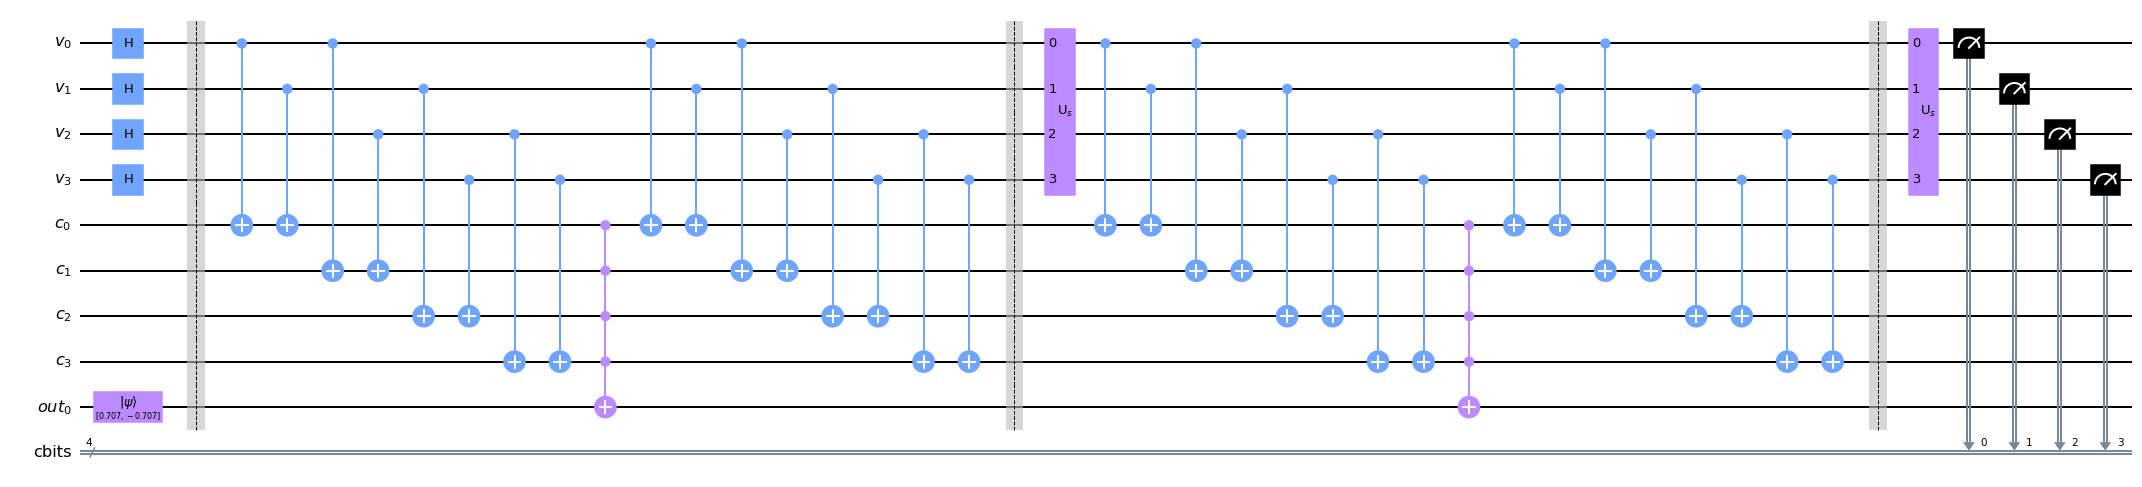

In [15]:
qc.measure(var_qubits, cbits) # Measure the variable qubits

qc.draw(fold=-1)

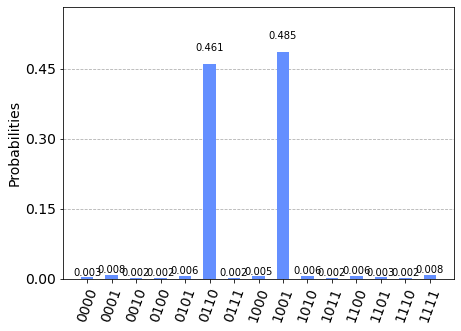

In [16]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

transpiled_qc = transpile(qc, qasm_simulator)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
plot_histogram(result.get_counts())

There are two qubits with much higher probability of measurement 0110 and 1001. These correspond to two possible solutions:

Solution1-

**v0 = 0**

**v1 = 1**

**v2 = 1**

**v3 = 0**

Solution2-

**v0 = 1**

**v1 = 0**

**v2 = 0**

**v3 = 1**